In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

a. Upload the dataset

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
from datasets import load_dataset
ds = load_dataset("stas/openwebtext-10k", split="train")
with open("complete.txt", "w", encoding="utf-8") as f:
    for entry in ds:
        f.write(entry['text'] + "\n")

with open("/content/complete.txt",'r',encoding='utf-8') as file:
  text = file.read()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

b.Tokenazing the datset

In [ ]:
text_set = sorted(list(set(text)))
vocab_size = len(text_set)
print(vocab_size)
print(text_set[:64])

encode = lambda word:[text_set.index(word[i]) for i in range(len(word))]
decode = lambda word:''.join([text_set[word[i]] for i in range(len(word))])

65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [ ]:
data = torch.tensor(encode(text))
data[:1000]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

c. Spliting the data

In [ ]:
length = int(len(data)*0.9)
train = data[:length]
valid = data[length:]

batch_size = 8 #number of inputs processed in the same time
block_size = 8 #length of the block

d. Small batch generation function that we called in every iteration (we can extract huge sequances using random aprroche)

In [ ]:
def get_batch(split):
    data = train if split == 'train' else valid
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
get_batch("train")

(tensor([[2726,  428, 3592, 2087, 1714,  202,   25,   39],
         [ 315,   26, 1133,   43,  681,  103,  612,  938],
         [   9, 1410, 2347,    6,  361, 1383,   35,  728],
         [ 119,  593,    5,  561,  571,  809,  844, 1245],
         [1100,  511,  122, 1140,  349,  217,    9,  189],
         [   8, 2964,   61, 1048,  617,  115,    4,   91],
         [  14, 3526,  640,  189,   52,  188,   22,    5],
         [1221,   30,  805,    8,    4,   76,   63,  213]], device='cuda:0'),
 tensor([[ 428, 3592, 2087, 1714,  202,   25,   39,   67],
         [  26, 1133,   43,  681,  103,  612,  938,   29],
         [1410, 2347,    6,  361, 1383,   35,  728,    5],
         [ 593,    5,  561,  571,  809,  844, 1245,    3],
         [ 511,  122, 1140,  349,  217,    9,  189,  469],
         [2964,   61, 1048,  617,  115,    4,   91,  617],
         [3526,  640,  189,   52,  188,   22,    5,   52],
         [  30,  805,    8,    4,   76,   63,  213,    3]], device='cuda:0'))

In [ ]:
batch_size = 16 #number of inputs processed in the same time
block_size = 32 #length of the block
num_iter = 10000
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 # size of the embeddings for example each token represented with 64 embedding
n_head = 4 # number of heads that works in parallel in multi headed
num_layers = 5
eval_interval = 100 #print losess each 100 iteration
eval_iters = 200

torch.manual_seed(1337)

E. create a head classe (represent a head in the architecture)

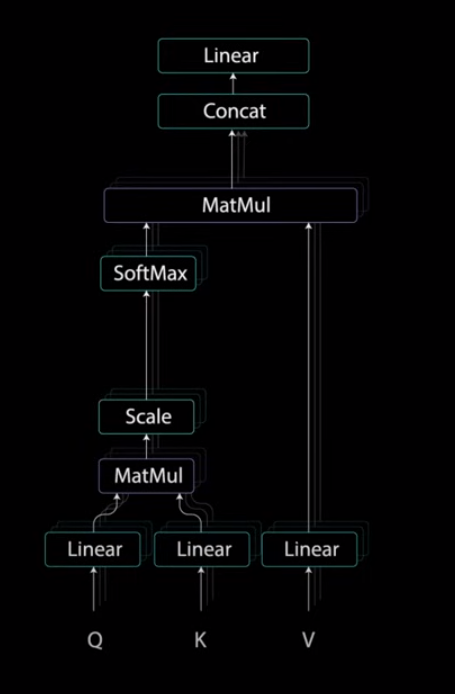

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
class Head(nn.Module):
  # constrcutor to define the linear function
  def __init__(self , head_size):
    super().__init__()
    self.key = nn.Linear(n_embd,head_size,bias=False)
    self.query = nn.Linear(n_embd,head_size,bias=False)
    self.value = nn.Linear(n_embd,head_size,bias=False)
    self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))#the masking layer for non ecovered tokens
    self.dropout = nn.Dropout(0.0)

  #like zipping the pipeline in the multiheaded in one method
  def forward(self , x):
    B,T,C  = x.shape #storing inpute batch size , the sequance length (token number, carecters in our case) , embedding size
    k= self.key(x)
    q= self.query(x)
    # calculate attention scores ("affinities")
    wei = q @ k.transpose(-2,-1) * C**-0.5 # a dot product followed by a scaling
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) #mask the toen we idn't descover yet
    wei = F.softmax(wei, dim=-1)
    v = self.value(x)
    out = wei @ v
    return out

class MultiHeadedAttention(nn.Module):
    def __init__(self , num_heads , head_size):
      super().__init__()
      self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
      self.proj = nn.Linear(n_embd, n_embd)
      self.dropout = nn.Dropout(0.0)

    #concatintae the result output heads matrix
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
  def __init__(self , n_embd):
    super().__init__()
    #creating a linear layer followed by a no linearity (using RELU activation)
    self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.0),
        )
  def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    # in the block we pass the input into a normalization layer and also the output heads
    # first for the residual connection + the feature normalization

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadedAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x



In [ ]:
class BigramLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.embeddings_table = nn.Embedding(vocab_size,n_embd)
    self.position_embeddings = nn.Embedding(block_size,n_embd) #position representation (token 2 is the first , 1 is the second .. etc)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(num_layers)]) #number of encoder blocks
    self.LayerN = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd , vocab_size)
  def forward(self , idx, targets=None): #generate the logits and the loss in case of training (forward propagtion)
    B , T = idx.shape #idx -> input data
    token_embd = self.embeddings_table(idx)
    pos_embd = self.position_embeddings(torch.arange(T, device=device))
    x = token_embd + pos_embd
    x = self.blocks(x)
    x = self.LayerN(x)
    logits = self.lm_head(x) # (B,T,vocab_size)

    if targets is None:
        loss = None
    else:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

    return logits, loss
  def generate(self , idx , max_number_tokens):
    for _ in range(max_number_tokens):
      idx_cond = idx[:, -block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1) # icluding the new token into the new one
    return idx

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

model = BigramLanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(num_iter):

    if iter % eval_interval == 0 or iter == num_iter - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step() # optimizing the weights here


step 0: train loss 8.1673, val loss 8.1513
step 100: train loss 6.2932, val loss 6.3566
step 200: train loss 5.9926, val loss 6.0913
step 300: train loss 5.6816, val loss 5.8626
step 400: train loss 5.4566, val loss 5.6679


KeyboardInterrupt: 

Z. tetsing

In [ ]:
import torch
block_size=8
context = "First Citizen:\nBefore we proceed any further"
converted = [encode(context[i*block_size:i*block_size+block_size]) for i in range(len(context)//block_size)]
converted = torch.tensor(converted , device=device)
print(converted)

tensor([[18, 47, 56, 57, 58,  1, 15, 47],
        [58, 47, 64, 43, 52, 10,  0, 14],
        [43, 44, 53, 56, 43,  1, 61, 43],
        [ 1, 54, 56, 53, 41, 43, 43, 42],
        [ 1, 39, 52, 63,  1, 44, 59, 56]], device='cuda:0')


In [ ]:
print(decode(m.generate(converted, max_number_tokens=2000)[0].tolist()))

First Citizen:
I brince?

SOMERSET:
We
be seek of Aufidal grave the gate
he art that us he hand?

MEXENES:
But conded.

HENRY BOLINGBROKE:
Norto find your mildne;
Whice mirted?

PAULINA:
Her, move to help know and be joy!
 less him; let humb on him speak; and thee years in us.
But at is loss
For I the callely aling to thy in all, and bouring with imed to-night,--'Sir the dangerupt for the
rist me to thy fled
At forful her blood.

HENRY BRUTH:
Prisadards.
With Edward hith cousany, tell repts
Infer for his needs, knees,
It ne'er his eam of a changed-foot, by we men.

CORIOLANUS:
What thy welcome, will cousin:
I should so, madamial of mucians
Of husbade.

VOMPEN LORENCE:
No must cour-vittrise so upon sorrow Richard:
Whit Clarence!
Yes, will hear nee, or the want beak the
were but we must be the manner, do so lady.

Provost comed
For him, till
but be no none Captures, the quite under or fact e subjectip you our woed no come out spectly like to the han the body twat doth Your tell for Glouc

Try with diffrent tokenizer

In [4]:
import sentencepiece as spm
spm.SentencePieceTrainer.train(input='/content/complete.txt', model_prefix='m', vocab_size=3000) #setting vocab to higher value to encode sub words
sp = spm.SentencePieceProcessor(model_file='/content/m.model')

In [5]:
data = torch.tensor(sp.encode(text),device=device)
data[:1000]

tensor([  54, 2892,  440,   47, 1164,  142,   32,   59, 1424,   10, 1103,  223,
         132,  243,   91,  946,   11,    4, 1847,  739,  346, 1268,   31,  231,
         192,   93,  546,   27,   20, 1967,   16,   12,   93,   25,  825,    6,
         525,  549, 1177,    3,   44,  150,   24,   38,  151, 1354,  132,  161,
          12, 1203,   22,    5,   81,    4,  393,   10,  528,  473,   77,   40,
           5, 1074,    3,    4, 2606,   11, 2540,    3,   28,   96,   25,  954,
         735,   29,    6,   49,  147,  383,  257,    3,  712,  123,  126, 1097,
         298,  147, 1169,   73,   63,   33,  845,   17,   34,    4, 1909,   10,
        1103,  223,  132,  243,   91,  946,   19,    3, 1082, 1126,   24,   20,
         527, 1143,   14,   32, 2718,  105,   10,    4, 1002,  160,   58,  898,
           5,   56,    4, 2465,  129,  544,   61,    3,   17,  124,   91,    4,
        1402,    3,   10,  338, 1223,    3,    7,    4,  305,  172,  726, 1711,
         772,  654,  322,   24,  615,  3

In [12]:
length = int(len(data)*0.95)
train = data[:length]
valid = data[length:]

batch_size = 8 #number of inputs processed in the same time
block_size = 8 #length of the block
vocab_size=4000

In [13]:
def get_batch(split):
    data = train if split == 'train' else valid
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
get_batch("train")

(tensor([[  59, 2010,  299,    7, 1365,  193,  695,   32],
         [ 247,  569,  202, 1511,   66,  311,    5, 1101],
         [   4,  981,  127,  183,  912,  352, 2320,    5],
         [   4,  331,   28,  319,    3,  159,  283,  105],
         [ 175,  722,   79,   53,  740, 2216,  224,  600],
         [   6, 2697,   10, 1092,    6,   49,  185,   36],
         [  23,  311,  345,  631,  337,    3,   92,   31],
         [ 301,  769,   75,   29, 1269,  307, 1211,    5]], device='cuda:0'),
 tensor([[2010,  299,    7, 1365,  193,  695,   32,  152],
         [ 569,  202, 1511,   66,  311,    5, 1101,  560],
         [ 981,  127,  183,  912,  352, 2320,    5,   81],
         [ 331,   28,  319,    3,  159,  283,  105,  310],
         [ 722,   79,   53,  740, 2216,  224,  600,    4],
         [2697,   10, 1092,    6,   49,  185,   36,  546],
         [ 311,  345,  631,  337,    3,   92,   31,  188],
         [ 769,   75,   29, 1269,  307, 1211,    5,  460]], device='cuda:0'))

In [14]:
batch_size = 8 #number of inputs processed in the same time
block_size = 16 #length of the block
num_iter = 10000
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 # size of the embeddings for example each token represented with 64 embedding
n_head = 4 # number of heads that works in parallel in multi headed
num_layers = 10
eval_interval = 100 #print losess each 100 iteration
eval_iters = 200

torch.manual_seed(1337)

In [15]:
import torch.nn as nn
from torch.nn import functional as F
class Head(nn.Module):
  # constrcutor to define the linear function
  def __init__(self , head_size):
    super().__init__()
    self.key = nn.Linear(n_embd,head_size,bias=False)
    self.query = nn.Linear(n_embd,head_size,bias=False)
    self.value = nn.Linear(n_embd,head_size,bias=False)
    self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))#the masking layer for non ecovered tokens
    self.dropout = nn.Dropout(0.0)

  #like zipping the pipeline in the multiheaded in one method
  def forward(self , x):
    B,T,C  = x.shape #storing inpute batch size , the sequance length (token number, carecters in our case) , embedding size
    k= self.key(x)
    q= self.query(x)
    # calculate attention scores ("affinities")
    wei = q @ k.transpose(-2,-1) * C**-0.5 # a dot product followed by a scaling
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) #mask the toen we idn't descover yet
    wei = F.softmax(wei, dim=-1)
    v = self.value(x)
    out = wei @ v
    return out

class MultiHeadedAttention(nn.Module):
    def __init__(self , num_heads , head_size):
      super().__init__()
      self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
      self.proj = nn.Linear(n_embd, n_embd)
      self.dropout = nn.Dropout(0.0)

    #concatintae the result output heads matrix
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
  def __init__(self , n_embd):
    super().__init__()
    #creating a linear layer followed by a no linearity (using RELU activation)
    self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.0),
        )
  def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    # in the block we pass the input into a normalization layer and also the output heads
    # first for the residual connection + the feature normalization

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadedAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x



In [16]:
class BigramLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.embeddings_table = nn.Embedding(vocab_size,n_embd)
    self.position_embeddings = nn.Embedding(block_size,n_embd) #position representation (token 2 is the first , 1 is the second .. etc)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(num_layers)]) #number of encoder blocks
    self.LayerN = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd , vocab_size)
  def forward(self , idx, targets=None): #generate the logits and the loss in case of training (forward propagtion)
    B , T = idx.shape #idx -> input data
    token_embd = self.embeddings_table(idx)
    pos_embd = self.position_embeddings(torch.arange(T, device=device))
    x = token_embd + pos_embd
    x = self.blocks(x)
    x = self.LayerN(x)
    logits = self.lm_head(x) # (B,T,vocab_size)

    if targets is None:
        loss = None
    else:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

    return logits, loss
  def generate(self , idx , max_number_tokens):
    for _ in range(max_number_tokens):
      idx_cond = idx[:, -block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1) # icluding the new token into the new one
    return idx

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

model = BigramLanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(num_iter):

    if iter % eval_interval == 0 or iter == num_iter - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step() # optimizing the weights here

step 0: train loss 8.4618, val loss 8.4609
step 100: train loss 6.7145, val loss 6.6824
step 200: train loss 6.6478, val loss 6.6397
step 300: train loss 6.5659, val loss 6.5544
step 400: train loss 6.4857, val loss 6.4810
step 500: train loss 6.4308, val loss 6.3917
step 600: train loss 6.3637, val loss 6.3668
step 700: train loss 6.3362, val loss 6.3390
step 800: train loss 6.2842, val loss 6.2793
step 900: train loss 6.2507, val loss 6.2409
step 1000: train loss 6.2119, val loss 6.2048
step 1100: train loss 6.1594, val loss 6.1792
step 1200: train loss 6.1256, val loss 6.1191
step 1300: train loss 6.0929, val loss 6.0939
step 1400: train loss 6.0461, val loss 6.0919
step 1500: train loss 6.0228, val loss 6.0389
step 1600: train loss 5.9997, val loss 6.0189
step 1700: train loss 5.9424, val loss 5.9670
step 1800: train loss 5.9417, val loss 5.9400
step 1900: train loss 5.9291, val loss 5.9211
step 2000: train loss 5.8721, val loss 5.8810
step 2100: train loss 5.8584, val loss 5.8884


In [11]:
import torch


block_size=8
context = "Social media have become home to two things in recent years?"
converted = [sp.encode(context)]
converted = torch.tensor(converted , device=device)
print(converted)
print(sp.decode(m.generate(converted, max_number_tokens=2000)[0].tolist()))

tensor([[2885,  924,   46,  773,  501,    7,  249,  623,   12, 1249,  307,  141]],
       device='cuda:0')
Social media have become home to two things in recent years? Why youngmmows Last year (the more), here as far, in my postmes.4EN-RA. Photo Disper if you will simply maintain them appously affect the economy. The first soragere’s's drescript, supporting how the company published games have not directed in many liikingans on an ostance since 1990s held well in 2011. Todayr cost: It is: D. New Elleuls is now 11 before able to monitor somed that, case to use work. But if we will my visits about make the home to soulne “Sheat me, Stew is the doctch and let as completely too delay flow. In Attorney removes, are Scottishing by wrong. Protroet, the temperature and is Russianted Act and good machine’s that took looks," said BL MPP’s conference’s boundonic be polyqual third industry. A creative-The Kenumtal Wation to try his seven synender status trendment on Ock cates and Bangic Street, C.

Experiment with diffrent data set ( a larger one )